In [325]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import datetime as dt
import json

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm_notebook as tqdm

In [326]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)     
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [327]:
DATA_DIR = pathlib.Path("./")

train_data = pd.read_csv(DATA_DIR.joinpath("activity_train.csv.zip"),
                         parse_dates=["date"], index_col="date",
                         compression="zip")
test_data = pd.read_csv(DATA_DIR.joinpath("activity_test.csv.zip"),
                        parse_dates=["date"], index_col="date",
                        compression="zip")
activity_test_target = pd.read_csv(DATA_DIR.joinpath("activity_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])

In [328]:
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)
activity_test_target = reduce_mem_usage(activity_test_target)

Mem. usage decreased to 215.50 Mb (0.0% reduction)
Mem. usage decreased to 45.08 Mb (0.0% reduction)
Mem. usage decreased to  0.66 Mb (0.0% reduction)


In [329]:
train_data['activity'] = train_data['activity'].shift(-1, freq='H')

<h3> append train and test

In [330]:
train_data = train_data.drop(['f28','atactic_1','atactic_2','atactic_3'],axis=1)
test_data = test_data.drop('f28',axis=1)

test_data['activity'] = np.nan

In [331]:
df = train_data.append(test_data)

<h4> add features

In [332]:
# df['f47'] = df['f47'].rolling(window=3).mean()

# df['f47_60'] = df['f47'].rolling(window=60).mean()

# df['f46_5'] = df['f46'].rolling(window=5).mean()

# df['f25/f24'] = df['f25'] / df['f24']

<h3> check correlated features

In [333]:
#so far works best with -0.2, 0.2

In [334]:
a = pd.DataFrame(df.corr().round(2)['activity'])
b = a[(a['activity'] > 0.2) | (a['activity'] < -0.2)]

correlated_cols = b.index.tolist()

b

,activity
f4,-0.66
f6,0.21
f7,-0.21
f8,0.35
f12,-0.65
f14,-0.23
f15,0.36
f22,-0.27
f23,-0.26
f24,-0.29


<h3> Model

In [335]:
correlated_cols

['f4',
 'f6',
 'f7',
 'f8',
 'f12',
 'f14',
 'f15',
 'f22',
 'f23',
 'f24',
 'f25',
 'f31',
 'f35',
 'f42',
 'f46',
 'f47',
 'activity']

In [336]:
X = df[correlated_cols]

X = X.dropna()

y = np.log1p(X['activity'].values)
X = X.drop('activity',axis=1)

In [337]:
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

MAPE = make_scorer(mape, greater_is_better = False)


model = LinearRegression()

score_means = []
score_stds = []
for i in tqdm(range(3,10)):
    scores = (cross_val_score(model, X,y, scoring = MAPE, cv = i)) 
    score_means.append(round(scores.mean(),4))
    score_stds.append(round(scores.std(),4))

print(score_means,'\n')
print(round(np.mean(score_means),4), round(np.mean(score_stds),4))

[-8.7634, -8.8303, -8.8359, -8.8462, -8.839, -8.8803, -8.8487] 

-8.8348 2.1521


In [339]:
if 'const' not in X.columns:
    X = (X- X.mean()) / X.std()
    X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

print('R2: ', round(results.rsquared, 3))
print('R2 adj: ', round(results.rsquared_adj, 3))
print('gap between R2 and adj R2: ', round(results.rsquared - results.rsquared_adj, 3)) 
print('\n')

print(results.summary())

R2:  0.465
R2 adj:  0.465
gap between R2 and adj R2:  0.0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 1.668e+04
Date:                Mon, 28 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:34:35   Log-Likelihood:            -8.7333e+05
No. Observations:              307153   AIC:                         1.747e+06
Df Residuals:                  307136   BIC:                         1.747e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

<h3> predict test

In [340]:
l = X.columns.tolist()
l.remove('const')

In [341]:
to_predict = df[df.index >= '2019-01-01'][l]
to_predict = to_predict.merge(activity_test_target, how = 'inner',left_index=True,right_index=True)

In [342]:
l.append('activity')
to_fit = df[l].dropna()

<h3>

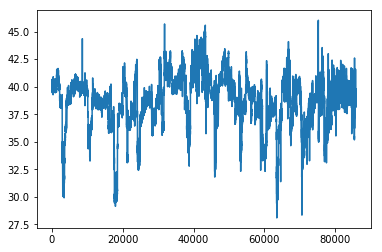

In [343]:
model = LinearRegression()
model.fit(to_fit.drop('activity',axis=1), to_fit['activity'])

pred = model.predict(to_predict)
plt.plot(pred)

In [344]:
submit = activity_test_target.copy()
submit['activity'] = np.expm1(pred)
submit.to_csv('катализатор_6.csv')